Epoch 1/20


/Users/lijingyi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0506 - val_loss: 4.9908e-04
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - val_loss: 3.7880e-04
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - val_loss: 3.6732e-04
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 3.9321e-04
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 8.1285e-04
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 2.9078e-04
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

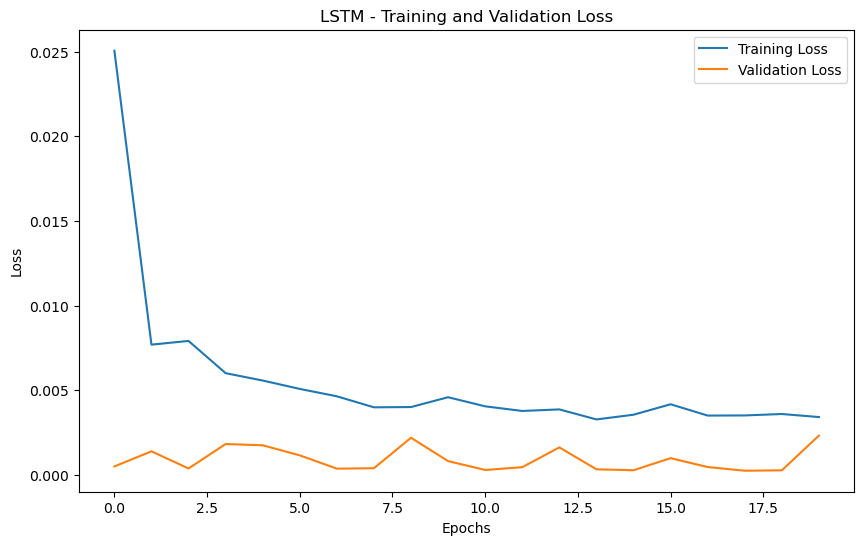

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


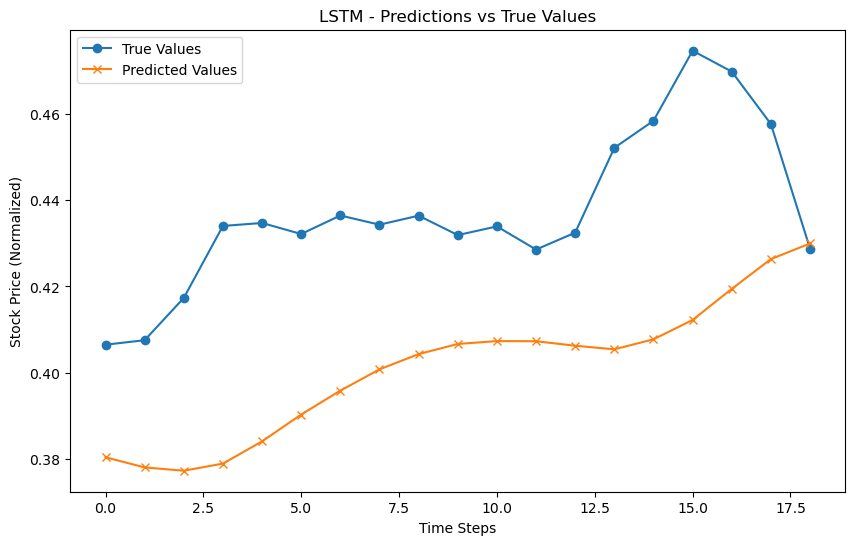

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load datasets
train_data = pd.read_csv('/Users/lijingyi/Desktop/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/Users/lijingyi/Desktop/Google_Stock_Price_Test.csv')

# Preprocess the data
def preprocess_data(data, features):
    data = data[features]
    data = data.replace(',', '', regex=True).astype(float)
    return data

features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data_cleaned = preprocess_data(train_data, features)
test_data_cleaned = preprocess_data(test_data, features)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data_cleaned)
test_scaled = scaler.transform(test_data_cleaned)

# Create time-series data
def create_time_series(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data) - 1):
        X.append(data[i - look_back:i])
        y.append(data[i, 3])  # Target is the 'Close' price
    return np.array(X), np.array(y)

look_back = 30
X_train, y_train = create_time_series(train_scaled, look_back)

# Adjust test dataset for insufficient data
def create_test_series(train_data, test_data, look_back):
    combined_data = np.vstack([train_data[-look_back:], test_data])
    return create_time_series(combined_data, look_back)

look_back_test = 10
X_test, y_test = create_test_series(train_scaled, test_scaled, look_back_test)

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Input shape for the model
input_shape = (look_back, X_train.shape[2])

# Build and train the LSTM model
lstm_model = build_lstm_model(input_shape)
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the LSTM model
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

lstm_mae, lstm_rmse = evaluate_model(lstm_model, X_test, y_test)

# Print Results
print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}")

# Visualizations
# Training and Validation Loss
def plot_training_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(lstm_history, "LSTM")

# Predictions vs True Values
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(f'{title} - Predictions vs True Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price (Normalized)')
    plt.legend()
    plt.show()

lstm_predictions = lstm_model.predict(X_test)
plot_predictions(y_test, lstm_predictions, "LSTM")
